In [2]:
import os, sys
os.chdir(os.path.abspath('..'))

In [3]:
import json, pickle
import argparse

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from torch.utils.tensorboard import SummaryWriter

In [4]:
%load_ext autoreload
%autoreload 2

import src.utils as utils
import src.preprocess_lib as preprocess_lib

In [5]:
config_dir = 'config_files/'
config_file = 'config0.json'
with open(config_dir + config_file, 'r') as f:config = json.load(f)


In [6]:
config["data"]["condition_tag_list"]

['months', 'weekdays', 'users', 'day_befores']

In [13]:
config["data"]["subsample_rate"]["user"] = 100
config["data"]["condition_tag_list"] = ["months", "weekdays", "users", "day_befores"]
config["data"]["ampute_params"]["b"] = 5

In [14]:
trainset, valset, conditioner, user_ids, months, condition_set, X_test, X_missing, num_missing_days, nonzero_mean, nonzero_std = preprocess_lib.prepare_data(config["data"])

Dataset: goi4_dp_full_Gipuzkoa
Loaded 2522880 consumption profiles from 365 dates and 6912 users.
Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles
Amputation Parameters...................a=0.85, b=5
Mean of enrolments: 53.03
Number of Training Points...............12414
Number of Testing Points.................5037
Number of Validation Points..............4063
Number of Missing Points.................3671
Found a matching user model in data/goi4_dp_full_Gipuzkoa/user_encoding_models/model_32


In [29]:
def quantile_loss(y_true, y_pred, quantiles):
    """
    Calculates the quantile loss for each quantile.
    Args:
        y_true (torch.Tensor): True values of shape (batch_size, forecast_horizon).
        y_pred (torch.Tensor): Predicted values of shape (batch_size, forecast_horizon, num_quantiles).
        quantiles (list): List of quantiles for which predictions are being made (e.g., [0.1, 0.5, 0.9]).
    
    Returns:
        torch.Tensor: The quantile loss.
    """
    losses = []
    for i, q in enumerate(quantiles):
        errors = y_true - y_pred[:, :, i]
        loss = torch.max((q - 1) * errors, q * errors).mean()
        losses.append(loss)
    
    return sum(losses)


In [30]:
import torch
import torch.nn as nn

class ForecastingQuantileLSTM(nn.Module):
    def __init__(self, input_size=1, context_size=0, hidden_size=64, num_layers=2, forecast_horizon=1, num_quantiles=3):
        """
        Args:
            input_size (int): Size of the time-series input (default is 1 for one-dimensional time-series).
            context_size (int): Size of the contextual information vector.
            hidden_size (int): Number of hidden units in each LSTM layer.
            num_layers (int): Number of LSTM layers.
            forecast_horizon (int): Number of timesteps to forecast.
            num_quantiles (int): Number of quantile predictions to make (e.g., 3 for [0.1, 0.5, 0.9]).
        """
        super(ForecastingQuantileLSTM, self).__init__()
        
        # LSTM network to handle time-series input
        self.lstm = nn.LSTM(input_size + context_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer to project the hidden state to the desired forecast horizon * number of quantiles
        self.fc = nn.Linear(hidden_size, forecast_horizon * num_quantiles)
        self.num_quantiles = num_quantiles
    
    def forward(self, time_series, context):
        # Concatenate time series and context along the feature dimension
        if context is not None:
            x = torch.cat((time_series, context), dim=-1)
        else:
            x = time_series

        # Pass through LSTM
        lstm_out, _ = self.lstm(x)
        
        # Take the last output from the LSTM (corresponding to T)
        last_hidden_state = lstm_out[:, -1, :]
        
        # Pass through the fully connected layer to predict the quantiles for the next L timesteps
        forecast = self.fc(last_hidden_state)
        
        # Reshape the output to (batch_size, forecast_horizon, num_quantiles)
        forecast = forecast.view(forecast.shape[0], -1, self.num_quantiles)
        
        return forecast


In [16]:
from torch.utils.data import DataLoader
import torch.optim as optim

In [48]:
# Hyperparameters
num_epochs = 50
batch_size = 32
learning_rate = 0.001
hidden_size = 50
num_layers = 3
forecast_horizon = 24  # Change this to the desired number of forecast steps

In [49]:
# Check if a GPU is available and set the device accordingly
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Assuming trainset and valset are instances of ConditionedDataset
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False)

# Model, Loss Function, and Optimizer
input_size = 1  # Assuming one-dimensional time-series
context_size = trainset[0][1].shape[0]  # Get size of contextual information from the dataset
# Define your quantiles (e.g., 0.1, 0.5, 0.9 for lower, median, and upper quantiles)
quantiles = [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9]

# Update the model definition
model = ForecastingQuantileLSTM(input_size=input_size, context_size=context_size - forecast_horizon, hidden_size=hidden_size, 
                                num_layers=num_layers, forecast_horizon=forecast_horizon, num_quantiles=len(quantiles)).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early Stopping Parameters
patience = 5  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
patience_counter = 0

# Training Loop with Quantile Loss and Early Stopping
for epoch in range(num_epochs):
    epoch_loss = 0.0
    model.train()  # Set the model to training mode
    
    # Training phase
    for batch_inputs, batch_conditions in train_loader:
        # Move inputs and conditions to the selected device
        batch_inputs, batch_conditions = batch_inputs.to(device), batch_conditions.to(device)

        batch_inputs = batch_inputs.unsqueeze(-1)  # Adding a dimension for input size if one-dimensional

        day_before = batch_conditions[:, -24:].unsqueeze(-1)
        batch_conditions = batch_conditions[:, :-24].unsqueeze(-2)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(day_before, batch_conditions.repeat_interleave(24, dim=-2))
        
        # Compute quantile loss
        loss = quantile_loss(batch_inputs.squeeze(), outputs, quantiles) 
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Average training loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_conditions in val_loader:
            # Move validation inputs and conditions to the selected device
            val_inputs, val_conditions = val_inputs.to(device), val_conditions.to(device)

            val_inputs = val_inputs.unsqueeze(-1)  # Adding a dimension for input size if one-dimensional

            day_before = val_conditions[:, -24:].unsqueeze(-1)
            val_conditions = val_conditions[:, :-24].unsqueeze(-2)

            # Forward pass
            val_outputs = model(day_before, val_conditions.repeat_interleave(24, dim=-2))
            
            # Compute validation loss
            loss = quantile_loss(val_inputs.squeeze(), val_outputs, quantiles)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)

    # Print epoch results
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the patience counter if validation loss improves
        # Optionally, save the best model state if needed
        # torch.save(model.state_dict(), "best_quantile_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

print("Training complete.")


Epoch 1/50, Training Loss: 2.0921, Validation Loss: 1.7291
Epoch 2/50, Training Loss: 1.6041, Validation Loss: 1.3841
Epoch 3/50, Training Loss: 1.3094, Validation Loss: 1.2567
Epoch 4/50, Training Loss: 1.2390, Validation Loss: 1.2136
Epoch 5/50, Training Loss: 1.2046, Validation Loss: 1.1926
Epoch 6/50, Training Loss: 1.1741, Validation Loss: 1.1583
Epoch 7/50, Training Loss: 1.1502, Validation Loss: 1.1401
Epoch 8/50, Training Loss: 1.1304, Validation Loss: 1.1164
Epoch 9/50, Training Loss: 1.1078, Validation Loss: 1.1103
Epoch 10/50, Training Loss: 1.0954, Validation Loss: 1.0889
Epoch 11/50, Training Loss: 1.0779, Validation Loss: 1.0762
Epoch 12/50, Training Loss: 1.0667, Validation Loss: 1.0674
Epoch 13/50, Training Loss: 1.0574, Validation Loss: 1.0636
Epoch 14/50, Training Loss: 1.0487, Validation Loss: 1.0492
Epoch 15/50, Training Loss: 1.0474, Validation Loss: 1.0485
Epoch 16/50, Training Loss: 1.0371, Validation Loss: 1.0516
Epoch 17/50, Training Loss: 1.0284, Validation Lo

In [50]:
conditions_test = torch.tensor(conditioner.transform(condition_set["test"])).float().to(device)
day_befores = conditions_test[:, -24:].unsqueeze(-1)
conditions_test = conditions_test[:, :-24].unsqueeze(-2)

In [51]:
estimations_test = model(day_befores, conditions_test.repeat_interleave(24, dim=-2))
estimations_test = estimations_test.reshape(69,-1, quantiles.__len__()).cpu().detach().numpy()

In [60]:
user_idx = 42

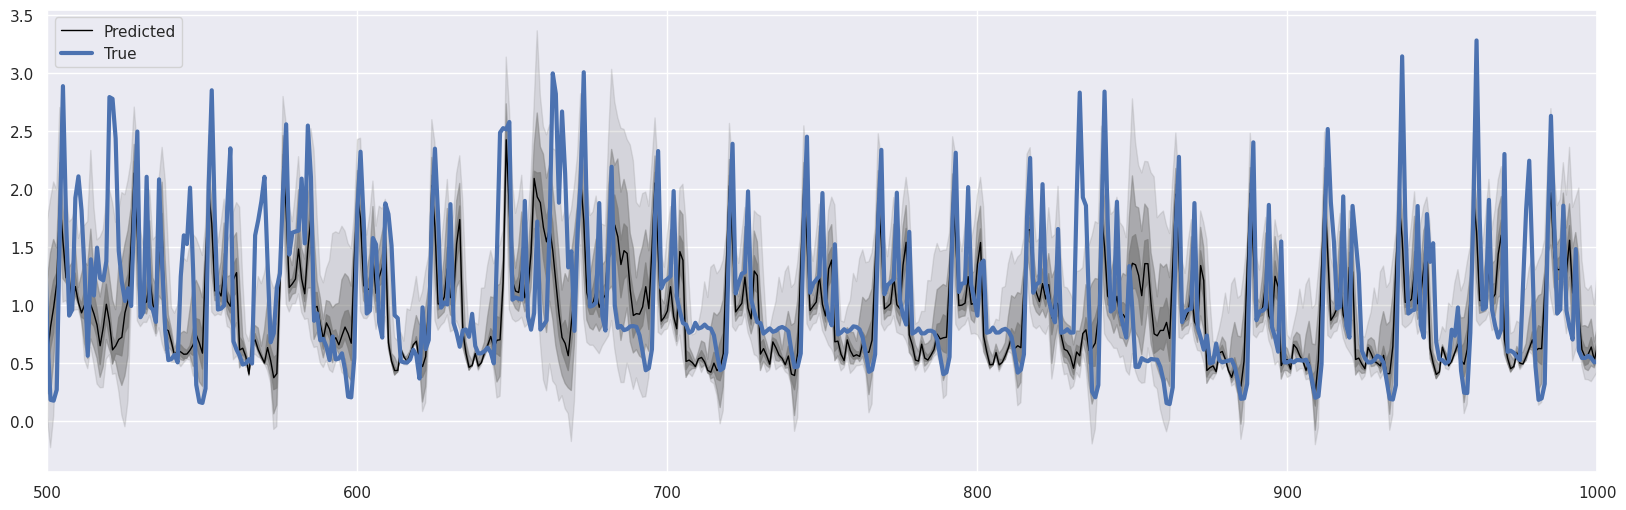

In [61]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(estimations_test[user_idx,:,quantiles.__len__()//2], label="Predicted", color="black", lw=1)
for i in range(quantiles.__len__()//2):
    ax.fill_between(np.arange(estimations_test.shape[1]), estimations_test[user_idx,:,i], estimations_test[user_idx,:,-(i+1)], alpha=2*quantiles[i], color="gray")

ax.plot(X_test.reshape(user_ids["train"][-1]+1,-1)[user_idx], label="True", lw=3)
ax.legend()

plt.xlim(500, 1000)
plt.show()


In [62]:
def calculate_quantile_loss(predictions, targets, quantiles):
    """
    Calculate the average quantile loss for multiple quantiles.
    
    Parameters:
        predictions (torch.Tensor): Predicted quantiles with shape (batch_size, output_size, num_quantiles)
        targets (torch.Tensor): Actual target values with shape (batch_size, output_size)
        quantiles (list of float): List of quantiles

    Returns:
        float: The average quantile loss over the predictions
    """
    total_loss = 0.0
    batch_size = targets.size(0)
    
    for i, q in enumerate(quantiles):
        errors = targets - predictions[:, :, i]
        loss = torch.max((q - 1) * errors, q * errors).mean()
        total_loss += loss.item()
    
    return total_loss / len(quantiles)

In [63]:
calculate_quantile_loss(torch.tensor(estimations_test).float(), torch.tensor(X_test.reshape(user_ids["train"][-1]+1,-1)), quantiles)

0.15032253657432962